In [1]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import _stop_words
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import gensim
from gensim import corpora


nltk_stopwords = set(stopwords.words('english'))
sklearn_stopwords = set(_stop_words.ENGLISH_STOP_WORDS)
my_stopwords = nltk_stopwords.union(sklearn_stopwords)
ps = PorterStemmer()
lem = WordNetLemmatizer()


def get_pos(w):
    tag = pos_tag([w])[0][1][0].upper()
    if tag == 'V':
        return wordnet.VERB
    elif tag == 'N':
        return wordnet.NOUN
    elif tag == 'J':
        return wordnet.ADJ
    elif tag == 'R':
        return wordnet.ADV
    else:
        return wordnet.NOUN

def token_ws(r):
    r1 = word_tokenize(r)
    r2 = [w.lower() for w in r1 if w.isalpha()]
    r3 = [w for w in r2 if not w in my_stopwords]
    r4 = [ps.stem(w) for w in r3]
    return r4
    
def token_wl(r):
    r1 = word_tokenize(r)
    r2 = [w.lower() for w in r1 if w.isalpha()]
    r3 = [w for w in r2 if not w in my_stopwords]
    r4 = [lem.lemmatize(w, get_pos(w)) for w in r3]
    return r4



class Nlp:
    
    def __init__(self, texts):
        if (type(texts) != list):
            texts = [texts]
        self.texts = texts      

    def Vectorizer(self, tokenizer, vec):
        if tokenizer == 'l':
            my_tokenizer = token_wl
        else:
            my_tokenizer = token_ws
        
        if vec == 'count':
            vectoring = CountVectorizer(tokenizer=my_tokenizer)
        elif vec == 'tfidf':
            vectoring = TfidfVectorizer(tokenizer=my_tokenizer)
            
        vec_reviews = vectoring.fit_transform(self.texts)
        vec_terms = vectoring.get_feature_names()
        vec_df = pd.DataFrame(vec_reviews.toarray(), columns=vec_terms)
        
        return vec_df
        
    def Cos_sim(self, tokenizer, vec):
        if tokenizer == 'l':
            my_tokenizer = token_wl
        else:
            my_tokenizer = token_ws
    
        if vec == 'count':
            vectoring = CountVectorizer(tokenizer=my_tokenizer)
        elif vec == 'tfidf':
            vectoring = TfidfVectorizer(tokenizer=my_tokenizer)
            
        vec_reviews = vectoring.fit_transform(self.texts)
        
        
        sim = cosine_similarity(vec_reviews)
        plt.figure(figsize=(8,8))
        sns.heatmap(sim, vmin = 0, vmax = 1, center = 0, cmap='PiYG', annot = True)
        plt.show()
    

    
    def Cluster(self, tokenizer, vec):
        if tokenizer == 'l':
            my_tokenizer = token_wl
        else:
            my_tokenizer = token_ws
    
        if vec == 'count':
            vectoring = CountVectorizer(tokenizer=my_tokenizer)
        elif vec == 'tfidf':
            vectoring = TfidfVectorizer(tokenizer=my_tokenizer)
            
        vec_reviews = vectoring.fit_transform(self.texts)
        vec_terms = vectoring.get_feature_names()
        vec_df = pd.DataFrame(vec_reviews.toarray(), columns=vec_terms)
        
        distance = []
        K = range(1, 5)
        for k in K:
            km1 = KMeans(n_clusters=k)
            km2 = km1.fit(vec_reviews)
            d = km2.inertia_
            distance.append(d)
        
        plt.figure(figsize=(10,8))
        plt.plot(K, distance)
        plt.show()
        
        num = int(input())
        
        km = KMeans(n_clusters=num, random_state=5)
        km.fit(vec_reviews)
        group = km.labels_.tolist()
        vec_df['cluster'] = group
        return vec_df
        
    def SA(self):
        try:
            sents = sent_tokenize(self.texts)
        except:
            sents = self.texts
            
        vader = SentimentIntensityAnalyzer()
        senti_list = []
        for s in sents:
            senti = vader.polarity_scores(s)
            senti_list.append(senti)
            
        senti_df = pd.DataFrame(senti_list)
        return senti_df
        
    def Topic(self, tokenizer, topic_num, word_num):
        if tokenizer == 'l':
            my_tokenizer = token_wl
        else:
            my_tokenizer = token_ws
        
        text_type = type(self.texts)
        if text_type != list:
            self.texts = list(self.texts)
            
        doc_1 = []
        for d in self.texts:
            d1 = my_tokenizer(d)
            doc_1.append(d1)
            
        gensim_terms = corpora.Dictionary(doc_1)
        doc_matrix = [gensim_terms.doc2bow(w) for w in doc_1]
        lda = gensim.models.ldamodel.LdaModel
        lda_model = lda(doc_matrix, num_topics = topic_num, id2word = gensim_terms, random_state = 0)
        
        print(lda_model.print_topics(num_words = word_num))
        
        for d in doc_matrix:
            print(lda_model[d])
            
        


In [2]:
doc1 = "I'm extremely happy and I would reccomend this TV to anyone who is looking for a great TV at an even better price."
doc2 = "The price was reasonable and the Roku remote is easy."
doc3 = "I give it 5 stars for price and quality. "
doc4 = "I have no complaints about the image quality."
doc5 = "The menus are just so much more smooth and easy to use."
doc6 = "The remote is simple and easy to use."

In [3]:
doc = [doc1, doc2, doc3, doc4, doc5, doc6]

In [4]:
review = Nlp(doc)

In [5]:
review.Topic('l', 3, 3)

[(0, '0.095*"tv" + 0.094*"price" + 0.092*"easy"'), (1, '0.122*"use" + 0.120*"easy" + 0.119*"remote"'), (2, '0.173*"quality" + 0.103*"price" + 0.100*"image"')]
[(0, 0.93192905), (1, 0.03384125), (2, 0.03422971)]
[(0, 0.8764262), (1, 0.06502725), (2, 0.05854654)]
[(0, 0.0886123), (1, 0.084283814), (2, 0.82710385)]
[(0, 0.08368977), (1, 0.08413972), (2, 0.8321705)]
[(0, 0.8484153), (1, 0.08364961), (2, 0.06793506)]
[(0, 0.07184369), (1, 0.8607296), (2, 0.06742668)]


In [6]:
review.Vectorizer('l', 'count')

complaint  easy  extremely  great  happy  image  look  menu  price  \
0          0     0          1      1      1      0     1     0      1   
1          0     1          0      0      0      0     0     0      1   
2          0     0          0      0      0      0     0     0      1   
3          1     0          0      0      0      1     0     0      0   
4          0     1          0      0      0      0     0     1      0   
5          0     1          0      0      0      0     0     0      0   

   quality  reasonable  reccomend  remote  roku  simple  smooth  star  tv  \
0        0           0          1       0     0       0       0     0   2   
1        0           1          0       1     1       0       0     0   0   
2        1           0          0       0     0       0       0     1   0   
3        1           0          0       0     0       0       0     0   0   
4        0           0          0       0     0       0       1     0   0   
5        0           0          0       1     0       1       0     0   0   

   use  well  
0    0     1  
1    0     0  
2    0     0  
3    0     0  
4    1     0  
5    1     0

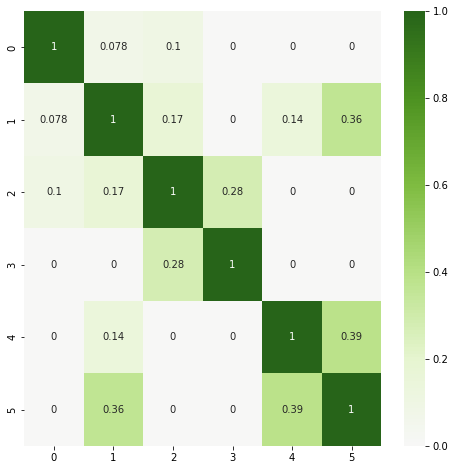

In [7]:
review.Cos_sim('l', 'tfidf')

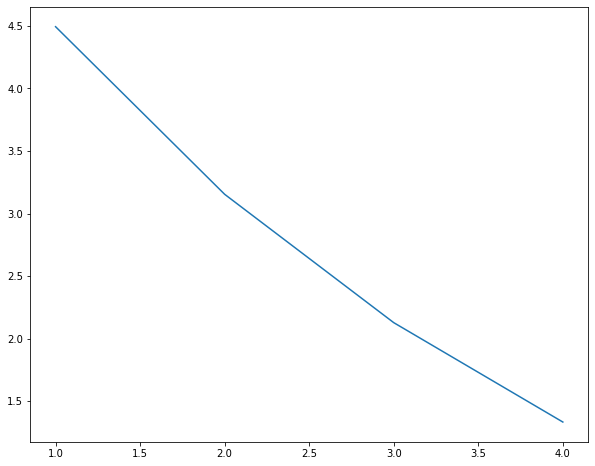

 2


complaint      easy  extremely     great     happy     image      look  \
0   0.000000  0.000000   0.308911  0.308911  0.308911  0.000000  0.308911   
1   0.000000  0.363319   0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.611713  0.000000   0.000000  0.000000  0.000000  0.611713  0.000000   
4   0.000000  0.389967   0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.000000  0.411964   0.000000  0.000000  0.000000  0.000000  0.000000   

       menu     price   quality  ...  reccomend    remote     roku    simple  \
0  0.000000  0.213863  0.000000  ...   0.308911  0.000000  0.00000  0.000000   
1  0.000000  0.363319  0.000000  ...   0.000000  0.430336  0.52479  0.000000   
2  0.000000  0.471964  0.559022  ...   0.000000  0.000000  0.00000  0.000000   
3  0.000000  0.000000  0.501613  ...   0.000000  0.000000  0.00000  0.000000   
4  0.563282  0.000000  0.000000  ...   0.000000  0.000000  0.00000  0.000000   
5  0.000000  0.000000  0.000000  ...   0.000000  0.487953  0.00000  0.595054   

     smooth      star        tv       use      well  cluster  
0  0.000000  0.000000  0.617823  0.000000  0.308911        0  
1  0.000000  0.000000  0.000000  0.000000  0.000000        1  
2  0.000000  0.681722  0.000000  0.000000  0.000000        0  
3  0.000000  0.000000  0.000000  0.000000  0.000000        0  
4  0.563282  0.000000  0.000000  0.461900  0.000000        1  
5  0.000000  0.000000  0.000000  0.487953  0.000000        1  

[6 rows x 21 columns]

In [8]:
review.Cluster('l', 'tfidf')

In [9]:
review.SA()

neg    neu    pos  compound
0  0.000  0.621  0.379    0.8999
1  0.000  0.756  0.244    0.4404
2  0.000  1.000  0.000    0.0000
3  0.495  0.505  0.000   -0.5994
4  0.000  0.777  0.223    0.4877
5  0.000  0.707  0.293    0.4404

In [10]:
doc_2 = 'I am a dog'

In [11]:
esteem = Nlp(doc_2)

In [12]:
esteem.texts

['I am a dog']

In [13]:
esteem.Vectorizer('l', 'tfidf')

dog
0  1.0

In [14]:
esteem.Topic('l', 3, 3)

[(0, '1.000*"dog"'), (1, '1.000*"dog"'), (2, '1.000*"dog"')]
[(0, 0.32706723), (1, 0.35950157), (2, 0.31343123)]


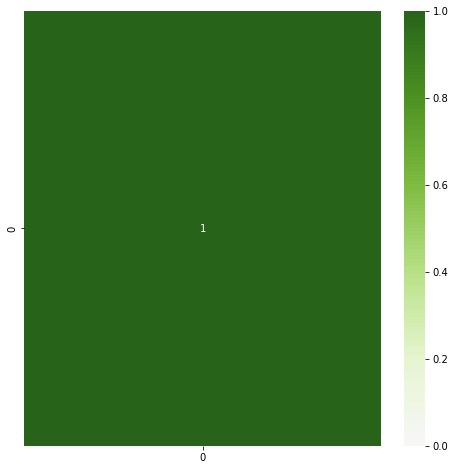

In [15]:
esteem.Cos_sim('l', 'tfidf')

In [16]:
esteem.Cluster('l', 'tfidf')

ValueError: n_samples=1 should be >= n_clusters=2.

In [17]:
esteem.SA()

neg  neu  pos  compound
0  0.0  1.0  0.0       0.0